# TP : Régression Ridge, Lasso et Elastic Net

## Objectifs
- Comprendre le rôle de la régularisation (L2, L1, combinaison).
- Relier théorie et pratique à travers des exercices et du code.
- Savoir choisir les hyperparamètres ($\lambda, \gamma$) via validation croisée.

## 0. Introduction
Dans ce TP, nous allons explorer trois variantes de la régression pénalisée :
- **Ridge regression (L2)**
- **Lasso regression (L1)**
- **Elastic Net (L1 + L2)**

## 1. Régression linéaire et colinéarité

**Question 1: expliquer ce que fait le code ci-dessous.**

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

rng = np.random.RandomState(42)
n = 200

# Colinéarité forte mais imparfaite -> ?
x1 = rng.normal(0, 1, n)
x2 = rng.normal(0, 1, n)   

# Variables bruitées supplémentaires (parasites)
X_noise = rng.normal(0, 1, size=(n, 2))
X = np.column_stack([x1, x2, X_noise])

# Vraie relation + bruit de sortie
beta_true = np.array([3.0, -2.0] + [0.0]*2)
y = X @ beta_true + rng.normal(0, 1.0, n)  # bruit non négligeable

Ce code prépare des données pour une régression linéaire multiple avec :
- Deux variables explicatives principales (x1 et x2) : générées indépendamment.
- variable de bruit (X_noise) parasites, sans impact significatif sur y (coefficients nuls dans beta_true).
- Un bruit gaussien : rng.normal(0, 1.0, n). Ajoute un bruit non négligeable à y.

On peut donc prévoir par la suite que l'on va étudier l'impact du bruit et de la variables parasites sur les performances d'un modèle de régression linéaire. 

**Remarque :** le commentaire "Colinéarité forte mais imparfaite" semble faux puisque justement dans cette section x1 et x2 ne sont pass colinéaire contrairement à la suite du TP.

**Question 2: entrainer un modèle de linéaire permettant de recouvrer la relation entre $y$ et les variables $x_1$ et $x_2$. Afficher les valeurs des coefficients du modèle. Cela vous parait-il cohérent?**

In [156]:
model = LinearRegression()
model.fit(X, y)
print(model.coef_)

[ 2.97658489 -2.13594131 -0.05913546  0.05298412]


- Comparaison avec `beta_true` :
  - $\hat{\theta}_1 = 2.976$ (proche de 3.0)
  - $\hat{\theta}_2 = -2.136$ (proche de -2.0)
  - $\hat{\theta}_3 = -0.059$ (proche de 0, variable parasite)
  - $\hat{\theta}_4 = 0.053$ (proche de 0, variable parasite)

Ces résultats semblent cohérents. Le bruit ajouté à `y` (avec un écart type = 1.0) est suffisant pour expliquer les petites différences entre les coefficients estimés et les vrais coefficients (`beta_true`).

Le modèle fonctionne bien dans ce cas, car il n’y a ni colinéarité ni problème structurel dans les données.

On va maintenant supposer que les deux premières variables sont colinéaires. 

In [157]:
rng = np.random.RandomState(42)
n = 200

# Colinéarité forte mais imparfaite
x1 = rng.normal(0, 1, n)
x2 = x1 + 0.05*rng.normal(0, 1, n)   # corr(x1,x2) ~ 0.998

# Variables bruitées supplémentaires (parasites)
X_noise = rng.normal(0, 1, size=(n, 2))
X_colinear = np.column_stack([x1, x2, X_noise])

# Vraie relation + bruit de sortie
beta_true = np.array([3.0, -2.0] + [0.0]*2)
y = X_colinear @ beta_true + rng.normal(0, 1.0, n)  # bruit non négligeable

**Question 3: quel est l'impact de l'ajout de cette variable sur les coefficients de la régression linéaire?**

En ajoutant cette corrélation quasi parfaite entre x1 et x2 : (corrélation ≈ 0.998)

x1 et x2 apportent la **même information** : La matrice $X^T X$ est non inversible.

Les coefficients $\hat{\theta}_2$ et $\hat{\theta}_3$ deviennent non identifiables.

Il existe une **infinité** de solutions qui donnent la même prédiction $\hat{y}$​.


In [158]:
model.fit(X_colinear, y)
print(model.coef_)

[ 5.69541114 -4.71882625 -0.05913546  0.05298412]


Dans le cas de la colinéarité forte, nous remarquons que les coeficients cette fois ci ne sont plus proche des $\Beta_i$ vu que nous avons ajouté une corrélation entre x1 et x2. 

Ce qui explique bien le problème de multicolinéarité en régression linéaire.

### Exercice : non-unicité des coefficients en cas de colinéarité parfaite

Considérons deux variables explicatives parfaitement colinéaires :

$$
x_{1} = (1,2)^\top,
\quad x_{2} = (2,4)^\top, 
\quad y = (3,6)^\top.
$$

1. Construire la matrice $X = \begin{bmatrix} x_1 , x_2 \end{bmatrix}$.  Vérifier que la matrice de Gram est non inversible (son déterminant doit être nul).  
2. Écrire le problème des moindres carrés associé à cet exemple.
3. Montrer que toutes les solutions qui vérifient $\beta_1 + 2\beta_2 = 3$ donnent exactement la même prédiction $\hat y = y$.  
4. En conclure que la solution des MCO n’est **pas unique**.


Votre réponse: 

**1. matrice X, matrice de Gram**
$$
x_1 = \begin{pmatrix} 1 \\ 2 \end{pmatrix}, \quad x_2 = \begin{pmatrix} 2 \\ 4 \end{pmatrix}, \quad y = \begin{pmatrix} 3 \\ 6 \end{pmatrix}
$$

$$
X = \begin{bmatrix} x_1 & x_2 \end{bmatrix} = \begin{bmatrix} 1 & 2 \\ 2 & 4 \end{bmatrix}
$$

Matrice de Gram $X^T X $ :
$$
X^T X = \begin{bmatrix} 1 & 2 \\ 2 & 4 \end{bmatrix}^T \begin{bmatrix} 1 & 2 \\ 2 & 4 \end{bmatrix} = \begin{bmatrix} 5 & 10 \\ 10 & 20 \end{bmatrix}
$$

$$
\det(X^T X) = 100 - 100 = 0
$$

La matrice de Gram est donc **non inversible**. Donc le problème des moindres carrés n’a pas de solution unique.


**2. Problème des moindres carrés associé**

On cherche à minimiser :
$$
\| y - X \hat{\beta} \|^2
$$

$$
X^T y = \begin{bmatrix} 1 & 2 \\ 2 & 4 \end{bmatrix}^T \begin{pmatrix} 3 \\ 6 \end{pmatrix} = \begin{pmatrix} 15 \\ 30 \end{pmatrix}
$$

$$
\begin{bmatrix} 5 & 10 \\ 10 & 20 \end{bmatrix} \begin{pmatrix} \beta_1 \\ \beta_2 \end{pmatrix} = \begin{pmatrix} 15 \\ 30 \end{pmatrix}
$$

**3. Toutes les solutions vérifiant $\beta_1 + 2\beta_2 = 3$ donnent $\hat{y} = y$**

Comme $x_2 = 2x_1$, toute solution $\beta$ telle que $\beta_1 + 2\beta_2 = 3$ donnera :
$$
\hat{y} = X \beta = \beta_1 x_1 + \beta_2 x_2 = \beta_1 x_1 + \beta_2 (2x_1) = (\beta_1 + 2\beta_2) x_1 = 3 x_1 = \begin{pmatrix} 3 \\ 6 \end{pmatrix} = y
$$

La matrice \(X^T X\) est **non inversible**, ce qui implique que le système d'équations normales a une **infinité de solutions**. Toutes ces solutions satisfont la relation \(\beta_1 + 2\beta_2 = 3\) et donnent la même prédiction $\hat{y} = y$.

Donc en cas de colinéarité parfaite, les coefficients $\beta$ ne sont pas identifiables de manière unique. Le problème des moindres carrés admet une infinité de solutions, mais toutes ces solutions mènent à la même prédiction $\hat{y}$.


Visuellement, on peut voir que l’ensemble des solutions forme une droite (sous-espace affine) dans le plan des coefficients. Chaque point sur cette droite donne exactement la même prédiction $\hat{y}$.

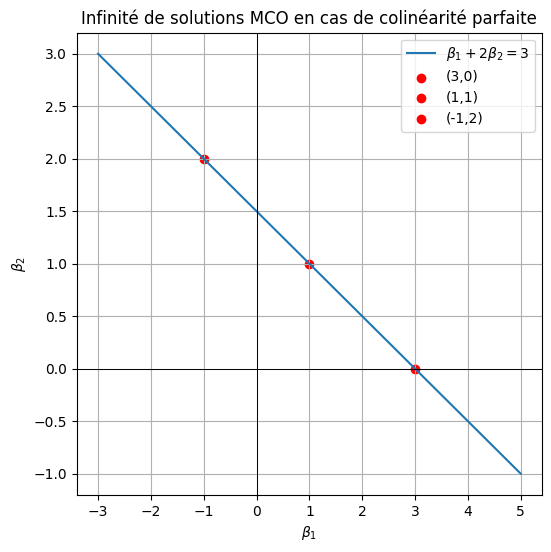

In [159]:
# Droite des solutions β1 + 2β2 = 3
beta2 = np.linspace(-1, 3, 100)
beta1 = 3 - 2*beta2  # relation

plt.figure(figsize=(6,6))

# tracer la droite avec un label
plt.plot(beta1, beta2, color="C0", label=r"$\beta_1 + 2\beta_2 = 3$")

# quelques solutions particulières
solutions = [(3,0), (1,1), (-1,2)]
for b1,b2 in solutions:
    plt.scatter(b1, b2, color="red", label=f"({b1},{b2})")

# axes
plt.axhline(0, color="black", linewidth=0.7)
plt.axvline(0, color="black", linewidth=0.7)

plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.title("Infinité de solutions MCO en cas de colinéarité parfaite")

plt.legend()
plt.grid(True)
plt.show()


## 2. Ridge Regression

**Question 4: on va maintenant passer à la régression ridge. Compléter le code ci dessous.**

**1. Principe de la régression Ridge**
La régression Ridge ajoute une **pénalité de régularisation** à la fonction de coût des moindres carrés ordinaires (OLS). Cette pénalité limite l'amplitude des coefficients du modèle, ce qui les rend plus stables et interprétables.

**Fonction de coût :**
La régression Ridge minimise la fonction suivante :
$$
\underbrace{\| y - X \beta \|^2}_{\text{Erreur des moindres carrés}} + \underbrace{\lambda \|\beta\|^2}_{\text{Pénalité Ridge}}
$$

**Avantages :**
- **Stabilise les coefficients** : En cas de colinéarité, les coefficients estimés par OLS peuvent être très grands et instables. Ridge les "tire" vers zéro, ce qui réduit leur variance.
- **Réduit l'overfitting** : En limitant l'amplitude des coefficients, Ridge évite que le modèle s'adapte trop aux bruits des données d'entraînement.
- **Gère les matrices non inversibles** : Même si $ X^T X $ n'est pas inversible (par exemple en cas de colinéarité parfaite), Ridge peut trouver une solution grâce à la pénalité.


In [160]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import numpy as np

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(X_colinear, y, test_size=0.2, random_state=42)

# Modèle sans régularisation (OLS) + prédiction
model_ols = make_pipeline(StandardScaler(), LinearRegression())
model_ols.fit(X_train, y_train)
y_pred_ols = model_ols.predict(X_test)

# Modèle Ridge avec λ=1 + prédiction
model_ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)

# Affichage des valeurs des coefficients 
coef_ols = model_ols.named_steps['linearregression'].coef_
coef_ridge = model_ridge.named_steps["ridge"].coef_
print("Coefficients OLS :", coef_ols)
print("Coefficients Ridge :", coef_ridge)


# Affichage des erreurs (MSE/RMSE) sur les données tests
mse_ols = mean_squared_error(y_test, y_pred_ols)
rmse_ols = np.sqrt(mse_ols)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

print("\nErreurs OLS :")
print(f"MSE : {mse_ols:.4f}, RMSE : {rmse_ols:.4f}")

print("\nErreurs Ridge :")
print(f"MSE : {mse_ridge:.4f}, RMSE : {rmse_ridge:.4f}")


Coefficients OLS : [ 5.99493938 -5.08499062 -0.05418515  0.08738549]
Coefficients Ridge : [ 1.36788591 -0.46316358 -0.04226968  0.10643454]

Erreurs OLS :
MSE : 1.0441, RMSE : 1.0218

Erreurs Ridge :
MSE : 1.0351, RMSE : 1.0174


Qu'observez vous pour les valeurs des coefficients?

Comparé aux coeficients OLS, les coefficients Ridge sont plus petits et rapprochés les uns des autres. La régularisation Ridge réduit l'amplitude des coefficients.

La colinéarité entre x1 et x2 rend les coefficients instables et difficiles à interpréter avec OLS.

Ridge "tire" les coefficients vers zéro et les "stabilise".

Les erreurs entre OLS et Ridge sont très proches (l'erreur avec ridge est très légèrement inférieur)

### Faire varier $\lambda$

On va maintenant regarder comment choisir une valeur optimale pour $\lambda$. Nous disposons de deux stratégies.

1. Utilisation d'un échantillon de validation 
2. Validation croisée K-fold 

#### Train/Validation/Test Split 

On va maintenant séparer les données en 3 parties :

- Train : pour ajuster les coefficients 
- Validation : pour comparer différentes valeurs de 
- Test : pour évaluer une seule fois la performance finale du modèle choisi.

Attention, cette stratégie peut poser problème quand le dataset est petit car on « perd » beaucoup de données pour l’entraînement.

In [161]:
# Split train / valid / test
X_train, X_temp, y_train, y_temp = train_test_split(X_colinear, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

**Question 6: Définir une grille de recherche pour les valeurs de $\lambda$ (1e−3 à 1e3 sur une échelle logarithmique) et déclarer une liste pour stocker les mse associés à chaque hyperparamètre.** 

In [162]:
lambdas = np.logspace(-3, 3, num=50)

**Question 7: complété le code ci-dessous pour déterminer la meilleur valeur de $\lambda$ pour la régression ridge.**

In [163]:
mse_scores = []

for alpha in lambdas:
    model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred)
    mse_scores.append(mse)

# lambda qui minimise MSE
best_lambda_idx = np.argmin(mse_scores)
best_lambda = lambdas[best_lambda_idx]

print("\nMeilleur λ (validation split):", best_lambda)



Meilleur λ (validation split): 4.714866363457395


**Question 8: entrainer votre modèle sur train+valid avec le meilleur $\lambda$ et évaluer votre modèle sur les données test. Quel MSE obtenez vous?**

In [164]:
# Réentraînement sur train+valid avec ce λ
X_train_valid = np.vstack([X_train, X_valid])
y_train_valid = np.hstack([y_train, y_valid])

ridge_final = make_pipeline(StandardScaler(), Ridge(alpha=best_lambda))
ridge_final.fit(X_train, y_train)

y_pred = ridge_final.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
mse_scores.append(mse)

y_pred_test = ridge_final.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

print(f"MSE : {mse_test:.4f}")
print(f"RMSE : {rmse_test:.4f}")


MSE : 0.6156
RMSE : 0.7846


#### Validation croisée (k-fold CV)

- On découpe l'échantillon d'apprentissage en $k$ parties (folds)
- Pour chaque valeur de lambda, on entraine sur $k-1$ folds, et on valide sur le fold restant.
- On prend la valeur de $\lambda$ qui minimise l'erreur moyenne sur les k-folds.

**Question 9: utiliser RidgeCV pour déterminer le meilleur $\lambda$ avec 5 folds. Afficher le lambda ainsi que le MSE. On utilisera la même grille de recherche que précedemment.**

In [165]:
from sklearn.linear_model import RidgeCV
# k = 5
model_ridge_cv = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=lambdas, cv=5) 
)
model_ridge_cv.fit(X_train, y_train)
ridgecv_obj = model_ridge_cv.named_steps['ridgecv']
print(dir(ridgecv_obj))


['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__sklearn_tags__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_build_request_for_signature', '_decision_function', '_doc_link_module', '_doc_link_template', '_doc_link_url_param_generator', '_estimator_type', '_get_default_requests', '_get_doc_link', '_get_metadata_request', '_get_param_names', '_get_params_html', '_get_scorer', '_html_repr', '_parameter_constraints', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_set_intercept', '_validate_params', 'alpha_', 'alpha_per_target', 'alphas', 'best_score_', 'coef_', 'cv', 'fit', 'fit_intercept', 'gcv_mode', 'get_metadata_rou

In [166]:
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

# k = 5
model_ridge_cv = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=lambdas, cv=5)
)
model_ridge_cv.fit(X_train, y_train)

best_lambda = model_ridge_cv.named_steps['ridgecv'].alpha_
print("Meilleur lambda:", best_lambda)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_scores = []

for alpha in lambdas:
    model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    scores = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mse_scores.append(np.mean(scores))

print("MSE minimal:", np.min(mse_scores))


Meilleur lambda: 0.012648552168552958
MSE minimal: 0.994710693557281


### 3. Régression Lasso 

**Question 10: Reprendre la logique de ridge avec la régularisation Lasso. Déterminer la valeur optimal pour $\lambda$ (avec la technique de votre choix). Comparer les valeurs des coefficients et les MSE des deux modèles.**

In [167]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

lambdas = np.logspace(-3, 3, num=50)

X_train, X_test, y_train, y_test = train_test_split(X_colinear, y, test_size=0.2, random_state=42)

ridge_model = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=lambdas, cv=5)
)
ridge_model.fit(X_train, y_train)

best_lambda_ridge = ridge_model.named_steps['ridgecv'].alpha_
print("Meilleur λ pour Ridge :", best_lambda_ridge)

# Modèle Lasso avec validation croisée
lasso_model = make_pipeline(
    StandardScaler(),
    LassoCV(alphas=lambdas, cv=5, max_iter=10000) 
)
lasso_model.fit(X_train, y_train)

# Récupération du meilleur lambda et des coefficients pour Lasso
best_lambda_lasso = lasso_model.named_steps['lassocv'].alpha_
print("Meilleur λ pour Lasso :", best_lambda_lasso)

# Prédictions
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)

# Calcul des MSE
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("\nMSE Ridge :", mse_ridge)
print("MSE Lasso :", mse_lasso)


Meilleur λ pour Ridge : 0.0517947467923121
Meilleur λ pour Lasso : 0.001

MSE Ridge : 1.0286571673009814
MSE Lasso : 1.031962821322304


### 3. ElasticNet
**Question 11: Reprendre les questions précédentes avec le modèle elasticnet. Déterminer la valeur optimal pour $\lambda$ et pour $\gamma$. Comparer les valeurs des coefficients et les MSE des trois modèles.**

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

lambdas = np.logspace(-3, 3, num=200)
X_train, X_test, y_train, y_test = train_test_split(X_colinear, y, test_size=0.2, random_state=42)

# Ridge
ridge_model = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=lambdas, cv=5)
)
ridge_model.fit(X_train, y_train)
best_lambda_ridge = ridge_model[-1].alpha_
print("Meilleur λ pour Ridge :", best_lambda_ridge)

# Lasso
lasso_model = make_pipeline(
    StandardScaler(),
    LassoCV(alphas=lambdas, cv=5, max_iter=10000)
)
lasso_model.fit(X_train, y_train)
best_lambda_lasso = lasso_model[-1].alpha_
print("Meilleur λ pour Lasso :", best_lambda_lasso)

# Elastic Net
elastic_model = make_pipeline(
    StandardScaler(),
    ElasticNetCV(alphas=lambdas, cv=5,l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9], max_iter=10000, random_state=42)
)
elastic_model.fit(X_train, y_train)
best_lambda_elastic = elastic_model[-1].alpha_
best_gamma_elastic = elastic_model[-1].l1_ratio_
print("Meilleur λ pour Elastic Net :", best_lambda_elastic)
print("Gamma = ",best_gamma_elastic)

# Prédictions
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_elastic = elastic_model.predict(X_test)

# MSE
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
print("\nMSE Ridge :", mse_ridge)
print("MSE Lasso :", mse_lasso)
print("MSE Elastic Net :", mse_elastic)


Meilleur λ pour Ridge : 0.052310993080562605
Meilleur λ pour Lasso : 0.001
Meilleur λ pour Elastic Net : 0.001
Gamma =  0.9

MSE Ridge : 1.028570497965081
MSE Lasso : 1.031962821322304
MSE Elastic Net : 1.0289553223100465


## Bonus : Application à un dataset réel (Diabetes dataset)

Nous allons comparer OLS, Ridge, Lasso et Elastic Net non seulement via la validation croisée,  
mais aussi en séparant les données en un **train/test split** pour évaluer la performance finale.

### Étapes

1. Faire un train/test split (70/30).  
2. Ajuster OLS, RidgeCV, LassoCV, ElasticNetCV sur les données d’entraînement.  
3. Calculer et comparer les MSE et RMSE sur l’ensemble de test.
4. Comparer les coefficients des modèles 

In [170]:
from sklearn.datasets import load_diabetes
# Charger le dataset
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
print("Shape:", X.shape)

Shape: (442, 10)


In [175]:
# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [176]:
# Standardiser les données (Standard Scaler) + appliquer les 3 modèles 
lambdas = np.logspace(-3, 3, num=50)

# OLS
ols_model = make_pipeline(StandardScaler(), LinearRegression())
ols_model.fit(X_train, y_train)

# RidgeCV
ridge_model = make_pipeline(StandardScaler(), RidgeCV(alphas=lambdas, cv=5))
ridge_model.fit(X_train, y_train)
best_lambda_ridge = ridge_model[-1].alpha_

# LassoCV
lasso_model = make_pipeline(StandardScaler(), LassoCV(alphas=lambdas, cv=5, max_iter=10000))
lasso_model.fit(X_train, y_train)
best_lambda_lasso = lasso_model[-1].alpha_

# ElasticNetCV
elastic_model = make_pipeline(
    StandardScaler(),
    ElasticNetCV(alphas=lambdas, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, max_iter=10000)
)
elastic_model.fit(X_train, y_train)
best_lambda_elastic = elastic_model[-1].alpha_
best_l1_ratio = elastic_model[-1].l1_ratio_

# Pred
y_pred_ols = ols_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_elastic = elastic_model.predict(X_test)

# MSE, RMSE
mse_ols = mean_squared_error(y_test, y_pred_ols)
rmse_ols = np.sqrt(mse_ols)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)

mse_elastic = mean_squared_error(y_test, y_pred_elastic)
rmse_elastic = np.sqrt(mse_elastic)

print("MSE OLS :", mse_ols, "RMSE OLS :", rmse_ols)
print("MSE Ridge :", mse_ridge, "RMSE Ridge :", rmse_ridge)
print("MSE Lasso :", mse_lasso, "RMSE Lasso :", rmse_lasso)
print("MSE ElasticNet :", mse_elastic, "RMSE ElasticNet :", rmse_elastic)

# lambda
print("\n--- Paramètres optimaux ---")
print("λ Ridge :", best_lambda_ridge)
print("λ Lasso :", best_lambda_lasso)
print("λ ElasticNet :", best_lambda_elastic)
print("L1 ratio ElasticNet :", best_l1_ratio)

# coefficients
coef_ols = ols_model.named_steps['linearregression'].coef_
coef_ridge = ridge_model.named_steps['ridgecv'].coef_
coef_lasso = lasso_model.named_steps['lassocv'].coef_
coef_elastic = elastic_model.named_steps['elasticnetcv'].coef_

print("\nCoef OLS :", coef_ols)
print("Coef Ridge :", coef_ridge)
print("Coef Lasso :", coef_lasso)
print("Coef ElasticNet :", coef_elastic)

MSE OLS : 2821.750981001311 RMSE OLS : 53.120156070942706
MSE Ridge : 2819.9033164740044 RMSE Ridge : 53.102761853542084
MSE Lasso : 2816.1021752901424 RMSE Lasso : 53.066959355988566
MSE ElasticNet : 2820.0692919325124 RMSE ElasticNet : 53.10432460668822

--- Paramètres optimaux ---
λ Ridge : 1.151395399326447
λ Lasso : 0.1206792640639329
λ ElasticNet : 0.0030888435964774815
L1 ratio ElasticNet : 0.1

Coef OLS : [  1.35246724 -12.45426893  26.21004615  18.61443344 -43.26039442
  24.2556288    5.73862584  13.96342685  31.57521526   1.98339354]
Coef Ridge : [  1.4569512  -12.33204226  26.37680927  18.44908303 -31.99550676
  15.53785369   0.7987447   12.31902013  27.17561485   2.15142016]
Coef Lasso : [  1.34512198 -12.15961596  26.49168586  18.38621697 -29.93024527
  13.94390841  -0.          11.93820273  26.50481852   2.06347056]
Coef ElasticNet : [  1.4361888  -12.35903576  26.34942255  18.48430736 -34.17317697
  17.219739     1.75180874  12.63798187  28.02781549   2.11593583]


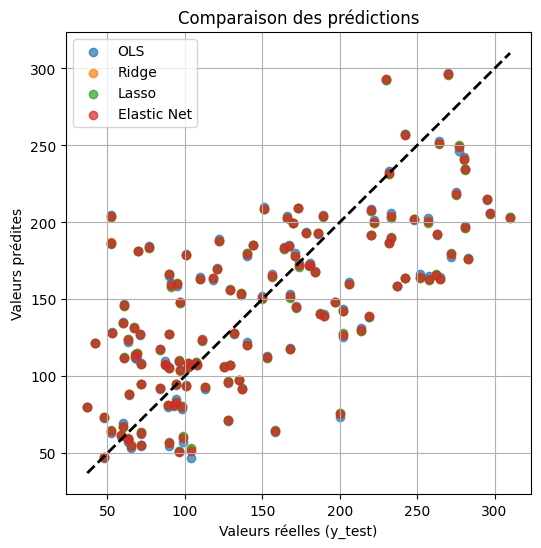

In [173]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ols, label='OLS', alpha=0.7)
plt.scatter(y_test, y_pred_ridge, label='Ridge', alpha=0.7)
plt.scatter(y_test, y_pred_lasso, label='Lasso', alpha=0.7)
plt.scatter(y_test, y_pred_elastic, label='Elastic Net', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Valeurs réelles (y_test)")
plt.ylabel("Valeurs prédites")
plt.title("Comparaison des prédictions")
plt.legend()
plt.grid(True)
plt.show()


Votre commentaire sur les résultats obtenus.